# 0.0 Imports

In [1]:
import math
import inflection
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.gridspec as gridspec
import xgboost             as xgb

from scipy      import stats       as ss
from matplotlib import pyplot as plt

from IPython.core.display  import HTML
from IPython.display       import Image

from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

from sklearn.metrics       import mean_absolute_error, mean_squared_error #mean_absolute_percentage_error,
from sklearn.linear_model  import LinearRegression, Lasso

import datetime

pd.__version__

'1.3.4'

## 0.1 Helper Functions

## 0.2 Loading Data

In [2]:
# Raw seria a marcação de arquivo que não foi limpo ainda (acabou de ler)
df_sales_raw = pd.read_csv("train.csv",low_memory = False)
df_store_raw = pd.read_csv("store.csv",low_memory = False)

In [3]:
# Merge (método da classe pandas) 1arg- documento que será referencia 2arg- arquivo que será anexado how:como fará e on a coluna em comum
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store")

# 1.0 Descrição dos Dados (Passo 1)

In [4]:
#fazer cópia dos dados, para não usar em cima do original
df1 = df_raw.copy()

In [5]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# função para deixar a lista em minúsculo e em snakecase(_)
snakecase = lambda x: inflection.underscore (x)
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

In [7]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print ("Number of Rows:{}".format(df1.shape[0]))
print ("Number of Cols:{}".format(df1.shape[1]))

Number of Rows:1017209
Number of Cols:18


## 1.3 Data Types

In [9]:
# mudar a data de object para forma de data
df1["date"] = pd.to_datetime(df1["date"])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA (Substituindo os dados faltantes)

In [11]:
### 3 formas de tratar os "na"
### 1- exclui, mas perde informação
### 2- ML para substituição no comportameno da coluna (Mediana ou media clusterização ou predição dos valores vazios)
### 3-pensar no negócio (pq gerou o NA)

In [12]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
180510,996,5,2015-02-20,7156,767,1,1,0,1,c,a,2870.0,7.0,2015.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [13]:
df1["competition_distance"].max()

75860.0

In [14]:
#competition_distance colocar 0 no lugar de NA Lambda é assim pq só tem 1 coluna
df1["competition_distance"] = df1["competition_distance"].apply (lambda x:200000.0 if math.isnan(x) else x)

#competition_open_since_month aqui aplica assim pq tem mais de uma coluna para analisar (por isso o Axis:1, se fosse axis 0 seria ao longo da linha)
df1["competition_open_since_month"] = df1.apply(lambda x: x["date"].month if math.isnan( x["competition_open_since_month"]) else x["competition_open_since_month"], axis=1)

#competition_open_since_year
df1["competition_open_since_year"] = df1.apply(lambda x: x["date"].year if math.isnan( x["competition_open_since_year"]) else x["competition_open_since_year"], axis=1)

#promo2_since_week
df1["promo2_since_week"] = df1.apply(lambda x: x["date"].week if math.isnan( x["promo2_since_week"]) else x["promo2_since_week"], axis=1)

#promo2_since_year
df1["promo2_since_year"] = df1.apply(lambda x: x["date"].year if math.isnan( x["promo2_since_year"]) else x["promo2_since_year"], axis=1)


In [15]:
#promo_interval Inplace=True faz a modificação direto na coluna e Fillna vai preencher com 0
month_map={1:"Jan", 2:"Fev", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}

df1["promo_interval"].fillna(0, inplace=True)

#Mapeia a o dicionario dentro da coluna (para saber se está dentro da promoção, se 0 não participa da promoção se 1 participa)
df1["month_map"] = df1["date"].dt.month.map(month_map)

df1["is_promo"] = df1[["promo_interval", "month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(",") else 0, axis=1)


In [16]:
#T = Transpose
df1.sample(5).T

,817493,425743,588113,693243,688662
store,984,599,179,499,378
day_of_week,6,7,1,5,2
date,2013-06-29 00:00:00,2014-06-15 00:00:00,2014-01-20 00:00:00,2013-10-18 00:00:00,2013-10-22 00:00:00
sales,6131,0,10284,3922,5569
customers,823,0,1123,648,937
open,1,0,1,1,1
promo,0,0,1,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,1
store_type,c,d,a,c,a


In [17]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types (Estatística Descritiva)


In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)

df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical 

In [21]:
#numérico
num_attributes = df1.select_dtypes(include=["int64", "float64"])
#categórico
cat_attributes = df1.select_dtypes(exclude=["int64", "float64","datetime64[ns]"])

In [22]:
num_attributes.sample(5)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
675263,359,7,0,0,0,0,0,4370.0,11,2013,0,44,2013,0
849655,811,5,5437,804,1,1,0,410.0,9,2012,0,22,2013,0
373652,916,4,5355,693,1,1,1,90.0,11,2012,0,32,2014,0
55447,813,5,4813,582,1,0,0,1560.0,9,2003,0,24,2015,0
596187,448,1,7551,722,1,0,0,3970.0,9,2009,0,3,2014,0


In [23]:
cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
139304,0,a,c,0,Mar
315594,0,a,a,0,Oct
50772,0,c,a,"Jan,Apr,Jul,Oct",Jun
368504,0,d,a,"Jan,Apr,Jul,Oct",Aug
810521,0,a,a,"Feb,May,Aug,Nov",Jul


### 1.7.1 Numerical Attributes 

In [24]:
#obs. T = Transpose
# Noção de negocios a partir dessas métricas(m) e erros

# Central Tendency - Mean Median
# média
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
# mediana
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtsosis
# Desvio padrão
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
# mínimo
d2 = pd.DataFrame(num_attributes.apply(min)).T
# máximo
d3 = pd.DataFrame(num_attributes.apply(max)).T

# Range
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
# Skew
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
# Kurtosis
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate da classe pandas na ordem na lista que quero ver
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
# dá nome as colunas
m.columns = (["attributes", "mim", " max", "range","mean" ,"median" ,"std" ,"skew" ,"kurtosis"])
m

,attributes,mim,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/Users/raquelrocha/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

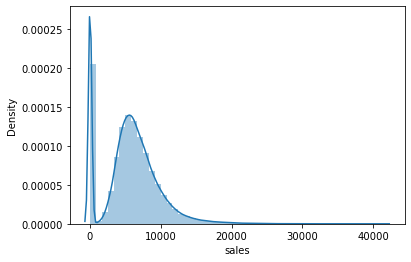

In [25]:
# Exemplo da distribuição das vendas(sales)
sns.distplot( df1["sales"])

/Users/raquelrocha/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

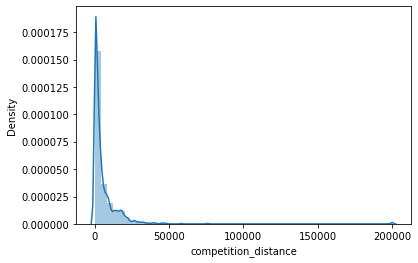

In [26]:
# Exemplo da distribuição da competition_distance
sns.distplot( df1["competition_distance"])

### 1.7.2 Categorical Attributes (Boxplot - vc tem medidas de desperção e tendência central em um local só ) 

In [27]:
# níveis cada variável categórica tem
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

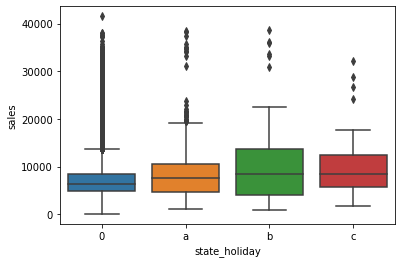

In [28]:
# Construir o boxplot
# Filtro 2 condições state_holiday e sales 
aux1 = df1[(df1["state_holiday"] !=0) & (df1["sales"] >0)]
# x(linha de referência ,nome da categoria) Y(o que vai medir, a dispersão data(dataframe)) 
sns.boxplot(x="state_holiday", y="sales", data=aux1)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

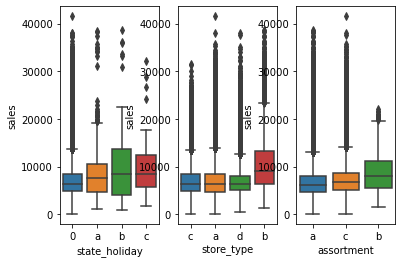

In [29]:
#colocando outras variáveis lado a lado
aux1 = df1[(df1["state_holiday"] !=0) & (df1["sales"] >0)]

plt.subplot (1, 3, 1)
sns.boxplot(x="state_holiday", y="sales", data=aux1)

plt.subplot (1, 3, 2)
sns.boxplot(x="store_type", y="sales", data=aux1)

plt.subplot (1, 3, 3)
sns.boxplot(x="assortment", y="sales", data=aux1)

# 2.0 Feature Engineering (Passo 2)
### (criar as variáveis, criar lista de hipóteses e validar as hipóteses)

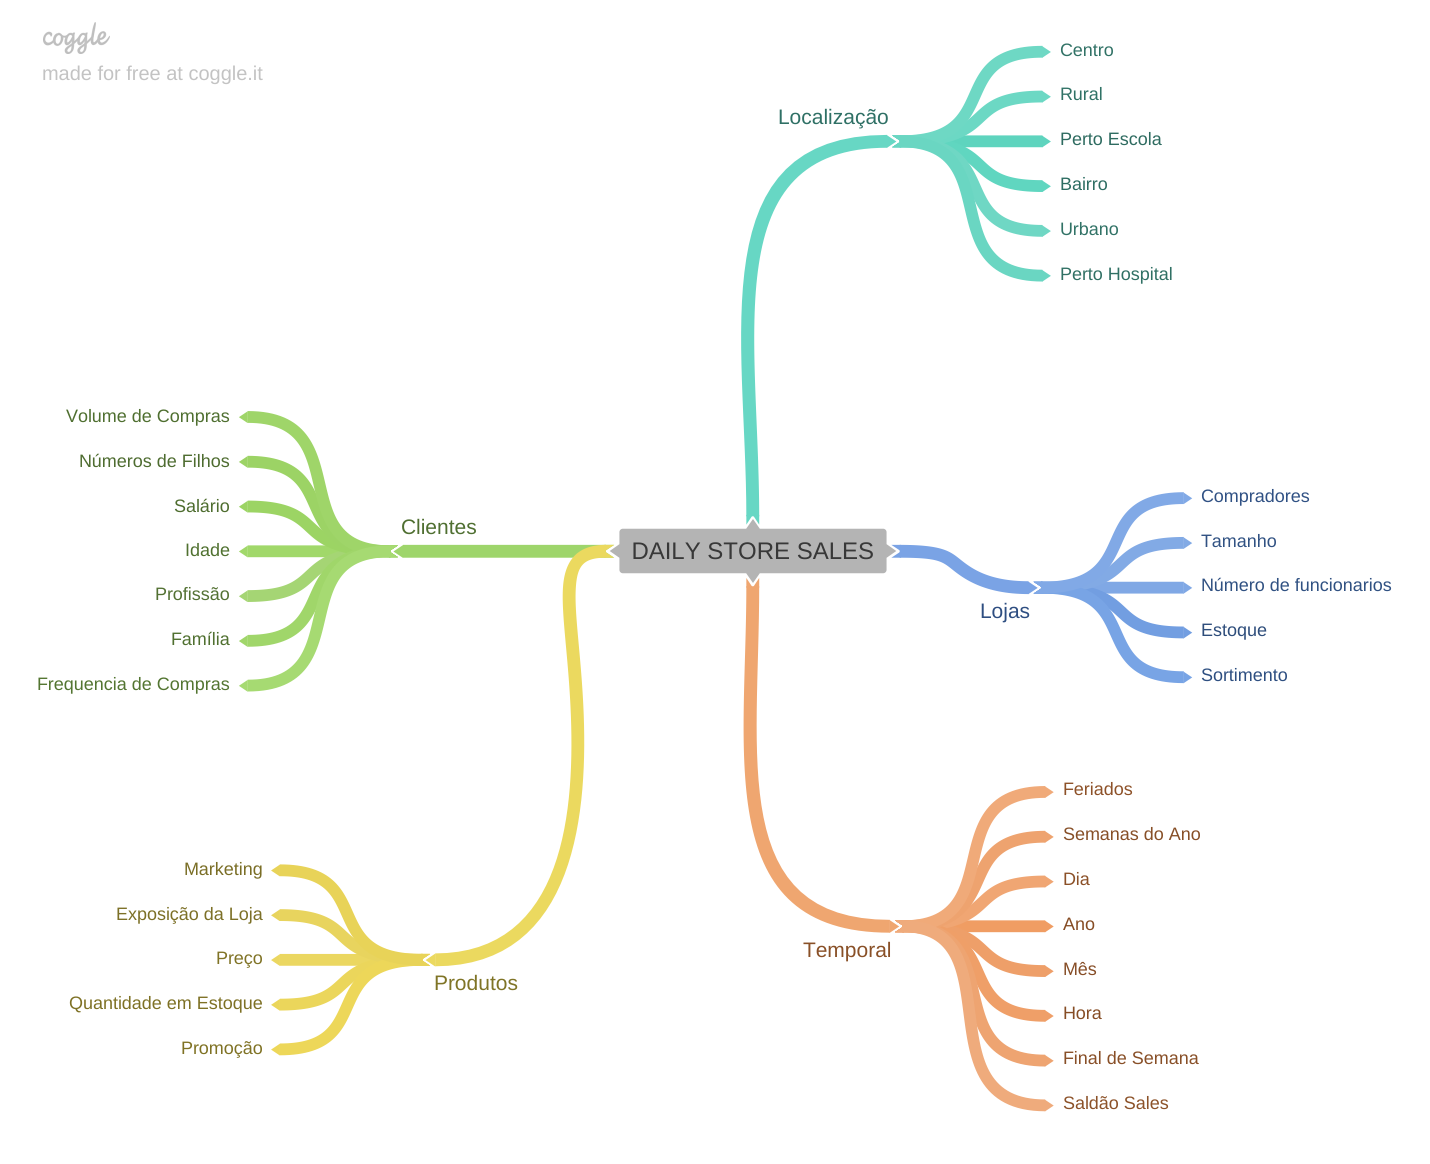

In [30]:
# aula 8 formar o mapa np=o stite coggle, salvar imagem e puchar ro arqvo jupyter
Image("MindMapHypothesis.png")

In [31]:
#Aula 10
df2 = df1.copy()

## 2.1 Criação das Hipóteses (aula 9)

### 2.1.1 Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

### 2.3 Feature Engineering (Aula 10 -Começamos copiando o arquivo df1 "df1.copy()")

In [32]:
# Variáveis a ser derivadas da variavel original Date 
# year 
df2["year"] = df2["date"].dt.year

# month
df2["month"] = df2["date"].dt.month

# day
df2["day"] = df2["date"].dt.day

# week of year
df2["week_of_year"] = df2["date"].dt.isocalendar().week

# year week (%Y ano, %W semana)
df2["year_week"] = df2["date"].dt.strftime("%Y-%W")


# competition since (esta em duas linhas nos dados, devemos juntar elas em uma só) day=1 para coeaçar no dia 1, considerando o mês como um todo
# método "datetime.datetime( year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1)"
# função em cima do método acima "df2.apply(lambda x: datetime.datetime( year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1)"
# se der problema de datetime not define, só importar o datetime
df2["competition_since"] = df2.apply( lambda x: datetime.datetime( year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1 ), axis=1 )
# diferença das duas (para conseguir o mês, P.S. subtrai o date comm o q vc quer)
df2["competition_time_month"] = ((df2["date"] - df2["competition_since"])/30).apply( lambda x: x.days).astype(int)

# promo since (juntar as duas informações(precisam estar como string),semana e o ano, e depois transformar no mês) (-) é para dar espaço entre as duas informações
df2["promo_since"] = df2["promo2_since_year"].astype(str) + "-" + df2["promo2_since_week"].astype(str)
# transformar novamente em data , (x + "-1", "%Y-%W-%w") = formato de resultadoano, semana do ano, semana de domingo a domingo (o w minúsculo)
df2["promo_since"] = df2["promo_since"].apply(lambda x: datetime.datetime.strptime (x + "-1", "%Y-%W-%w") - datetime.timedelta(days=7))
#subtrai as duas datas (subtrai o date comm o q vc quer)
df2["promo_time_week"]=((df2["date"] - df2["promo_since"])/7).apply(lambda x: x.days).astype(int)

# assortment, usar o apply para colocar em todas as linhas a função lambda, (a=basic, b=extra, c=extended (informações pegas no kaggle))
df2["assortment"] = df2["assortment"].apply(lambda x: "basic" if x =="a" else "extra" if x =="b" else "extended")

# state holiday usar o apply para colocar em todas as linhas a função lambda, (a=public holiday, b=easter holiday, c=christmas (informações pegas no kaggle))
df2["state_holiday"] = df2["state_holiday"].apply(lambda x: "public_holiday" if x =="a" else "easter_holiday" if x =="b" else "christmas" if x=="c" else "regular_day")



In [33]:
# Rodar as colunas para ver os codigos feitos anterior
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variáveis (Passo 3) Aula11

In [34]:
df3 = df2.copy()

In [35]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas
### começa com esse para diminuir volume dos dados que irá trabalhar.

In [36]:
# o que iremos filtrar ("open" != 0 "sales" > 0)
df3 = df3[(df3["open"] != 0) & (df3["sales"] > 0)]

## 3.2 Seleção das colunas

In [37]:
#o que não queremos ("customers", "open", "promo_interval", "month_map")
cols_drop = ["customers", "open","promo_interval", "month_map"]
# deletar (classe pandas "drop")
df3 = df3.drop(cols_drop,axis=1)

In [38]:
#verificar
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Análise Exploratória dos Dados - EDA (Passo 4)
### objetivos da análise exploratória dos dados

In [39]:
df4 = df3.copy()

## 4.1 Análise univariada

### 4.1.1 Responde variable

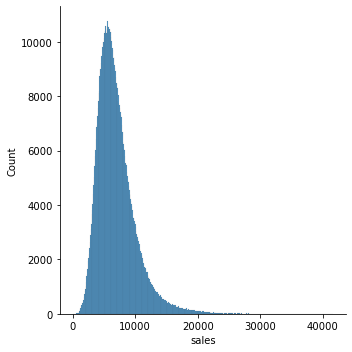

In [40]:
# distribuição das variáveis pode usar tanto "displot" quanto "histplot"
sns.displot(df4["sales"])

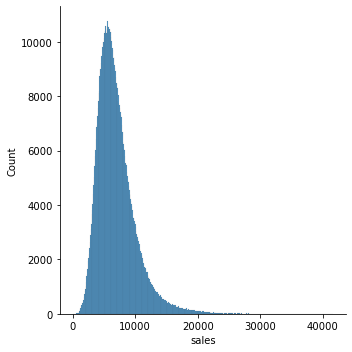

In [41]:
# se usar o "kde" mostra um histograma (ver pq não apareceu)
sns.displot(df4["sales"], kde=False)

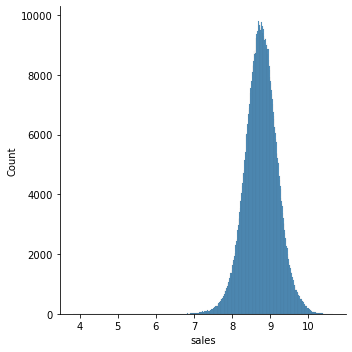

In [42]:
# formas de transformar o gráfico mais próximo de uma Distribuição normal
# pode usar bloxpot, exponencial
sns.displot(np.log (df4["sales"]))


### 4.1.2 Numerical variable

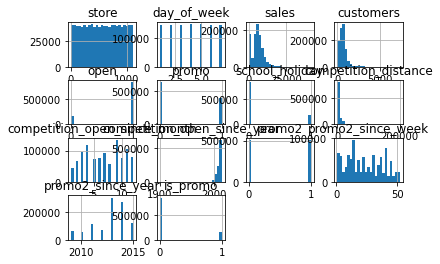

In [43]:
# plotar histograma de todas as variáveis numéricas
# Bins = Cada caixa, reatanguulo que vc coloca alguns dados agrupados
# ";" para não ficar mostrando a leitura dos dados antes do gráfico
num_attributes.hist(bins=25);

### 4.1.2 Categorical variable
#### p.s. tem muito sobre na internet de como transformar a categórica em númerica.

In [44]:
# contar quantas linhas tenho em cada uma das variávies categóricas
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [45]:
# para ficar apenas com os tipos de variáveis originais
df4["state_holiday"].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [46]:
# para ficar apenas com os tipos de variáveis originais
df4["store_type"].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [47]:
# para ficar apenas com os tipos de variáveis originais
df4["assortment"].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/Users/raquelrocha/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/raquelrocha/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/raquelrocha/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

<AxesSubplot:xlabel='sales', ylabel='Density'>

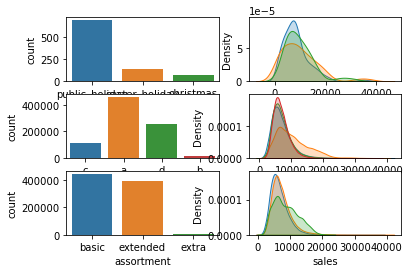

In [48]:
# as duas que não usamos são variáveis auxiliares que usamos para derivar outras
#aqui queremos saber o tipo de feriado que impacta mais


# state_holiday

# filtrar para ver melhor os dados, já que "regular day" possui muito mais infos que as demais variáveis de feriado (mais vendas)
# "sns.countplot(df4["state_holiday"])"
# esse faz uma especie de grid, matriz, para que os gráficos fiquem lado a lado (qtd por linhas, qtd por coluna, posição)
plt.subplot(3,2,1)

a = df4[df4["state_holiday"] != "regular_day"]
sns.countplot(a["state_holiday"])

# ver somente "public_holiday" na variável sales, shade deixa o gráfico mais transparente para sobrepor dois gráficos e ver melhor as comparações
plt.subplot(3,2,2)
sns.kdeplot (df4[df4["state_holiday"] == "public_holiday"]["sales"], label="public_holiday", shade=True)
sns.kdeplot (df4[df4["state_holiday"] == "easter_holiday"]["sales"], label="easter_holiday", shade=True)
sns.kdeplot (df4[df4["state_holiday"] == "christmas"]["sales"], label="christmas", shade=True)


# o que fez acima, replicar para as variáveis abaixo


# store_type
plt.subplot(3,2,3)
sns.countplot(df4["store_type"])

# ver somente "store_type" na variável sales, shade deixa o gráfico mais transparente para sobrepor dois gráficos e ver melhor as comparações
plt.subplot(3,2,4)
sns.kdeplot (df4[df4["store_type"] == "a"]["sales"], label="a", shade=True)
sns.kdeplot (df4[df4["store_type"] == "b"]["sales"], label="b", shade=True)
sns.kdeplot (df4[df4["store_type"] == "c"]["sales"], label="c", shade=True)
sns.kdeplot (df4[df4["store_type"] == "d"]["sales"], label="d", shade=True)


# assortment

plt.subplot(3,2,5)
sns.countplot(df4["assortment"])

# ver somente "assortment" na variável sales, shade deixa o gráfico mais transparente para sobrepor dois gráficos e ver melhor as comparações
plt.subplot(3,2,6)
sns.kdeplot (df4[df4["assortment"] == "basic"]["sales"], label="basic", shade=True)
sns.kdeplot (df4[df4["assortment"] == "extended"]["sales"], label="extended", shade=True)
sns.kdeplot (df4[df4["assortment"] == "extra"]["sales"], label="extra", shade=True)


## 4.2 Análise bivariada
### Análise exploratória de dados - Parte I, II e III

##### H1 Lojas com maior sortimentos deveriam vender mais.
***falso*** lojas com maior sortimento(assortment) vendem menos

<AxesSubplot:xlabel='year_week'>

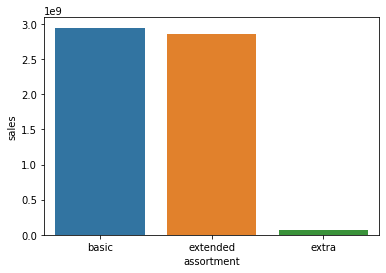

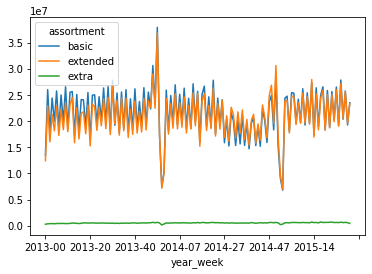

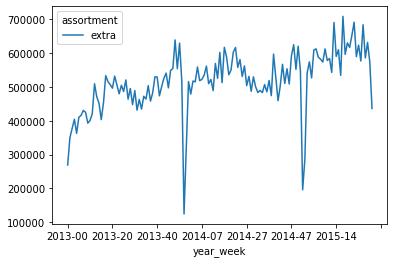

In [49]:
# agrupar o sales no assortment
aux1 = df4[["assortment","sales"]].groupby("assortment").sum().reset_index()
sns.barplot(x="assortment",y="sales",data=aux1);

# veremos por dia para ver se houve mudança de comportamento do cliente
aux2 = df4[["year_week","assortment","sales"]].groupby(["year_week","assortment"]).sum().reset_index()
#aqui estamos fazendo um pivot para ver cada linhas de forma única em cima dos valores dos dados 
aux2.pivot(index="year_week", columns="assortment", values="sales").plot()

#filtrar para pegar a linha do extra 
aux3 = aux2[aux2["assortment"]=="extra"]
aux3.pivot(index="year_week", columns="assortment", values="sales").plot()


##### H2 Lojas com competidores mais próximos deveriam vender menos.
***falso*** lojas com competidores mais próximos vendem mais

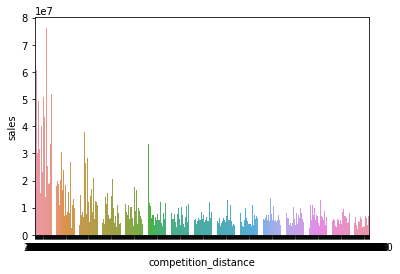

In [50]:
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").sum().reset_index()
sns.barplot(x="competition_distance",y="sales",data=aux1);


In [51]:
# faremos bin nesse caso para ficar mais fácil de ver os dados
# lista de 0 a 20000, em grupos de 1000 em 1000aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").sum().reset_index()

bins = list(np.arange(0,20000,1000))
# para saber em qual grupo os valores se encaixam, usando o método cut do pandas
aux1["competition_distance_binned"] = pd.cut(aux1["competition_distance"],bins=bins)


In [52]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
569,17290.0,3668097,"(17000, 18000]"
431,7890.0,5288733,"(7000, 8000]"
447,8400.0,5737615,"(8000, 9000]"
129,1430.0,6437314,"(1000, 2000]"


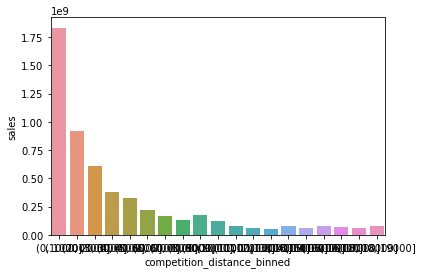

In [53]:
#resultado da Bin que foi feita
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").sum().reset_index()

bins = list(np.arange(0,20000,1000))

aux1["competition_distance_binned"] = pd.cut(aux1["competition_distance"], bins=bins)
aux2 = aux1[["competition_distance_binned", "sales"]].groupby("competition_distance_binned").sum().reset_index()

sns.barplot(x="competition_distance_binned", y="sales", data=aux2);


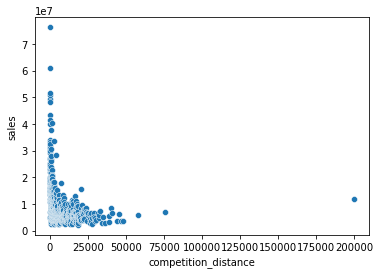

In [54]:
# validar se a variável é importante para o modelo
# gráfico de pontos, para ver a distribuição (concentração) dos valores
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").sum().reset_index()
sns.scatterplot(x="competition_distance",y="sales",data=aux1);


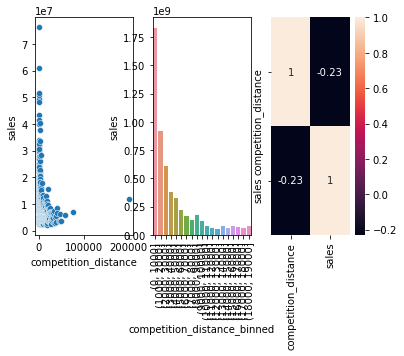

In [55]:
# gráfico para ver a correlação entre "competition_distance e sales"
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").sum().reset_index()

plt.subplot (1,3,1)
sns.scatterplot(x="competition_distance",y="sales",data=aux1);

plt.subplot (1,3,2)
bins = list(np.arange(0,20000,1000))
aux1["competition_distance_binned"] = pd.cut(aux1["competition_distance"], bins=bins)
aux2 = aux1[["competition_distance_binned", "sales"]].groupby("competition_distance_binned").sum().reset_index()
sns.barplot(x="competition_distance_binned", y="sales", data=aux2);
plt.xticks (rotation = 90);

# plot que mede a força da correlação
plt.subplot (1,3,3)
x=sns.heatmap (aux1.corr(method="pearson"),annot=True);
#rodar os numeros 90 graus para ler melhor (não deixar amontoados)
plt.xticks (rotation = 90);

##### H3 Lojas com competidores à mais tempo deveriam vendem mais.
***falso*** lojas com competidores a mais tempo vendem menos

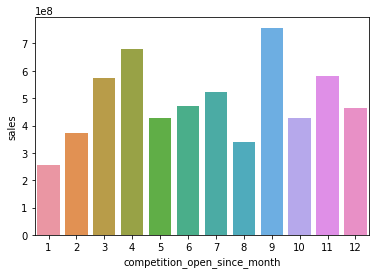

In [56]:
aux1 = df4[["competition_open_since_month","sales"]].groupby("competition_open_since_month").sum().reset_index()
sns.barplot(x="competition_open_since_month", y="sales", data=aux1);


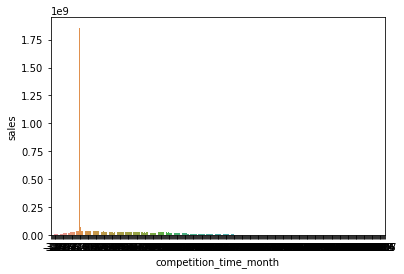

In [57]:
# gráfico ruim de ver
aux1 = df4[["competition_time_month","sales"]].groupby("competition_time_month").sum().reset_index()
sns.barplot(x="competition_time_month", y="sales", data=aux1);


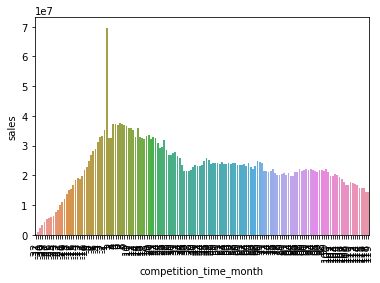

In [58]:
# gráfico com melhor visualização
aux1 = df4[["competition_time_month","sales"]].groupby("competition_time_month").sum().reset_index()
#ver os 120 primeiros meses de competicão e filtrar os competidores que tem diferente de 0
aux2 = aux1[(aux1["competition_time_month"] <120) & (aux1["competition_time_month"] != 0)]
sns.barplot(x="competition_time_month", y="sales", data=aux2);
plt.xticks(rotation=90);


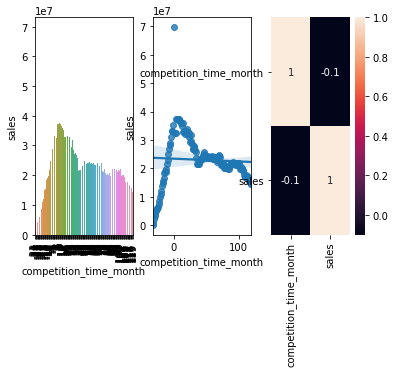

In [59]:
# plot que mede a força da correlação
plt.subplot (1,3,1)
aux1 = df4[["competition_time_month","sales"]].groupby("competition_time_month").sum().reset_index()
aux2 = aux1[(aux1["competition_time_month"] <120) & (aux1["competition_time_month"] != 0)]
sns.barplot(x="competition_time_month", y="sales", data=aux2);
plt.xticks(rotation=90);

#comportamento de crescimento e decaimento
plt.subplot (1,3,2)
sns.regplot(x="competition_time_month", y="sales", data=aux2);

# plot de correlação
plt.subplot (1,3,3)
x=sns.heatmap (aux1.corr(method="pearson"),annot=True);


##### H4 Lojas com promoções ativas por mais tempo deveriam vender mais.
***falso*** lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promoção

In [60]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


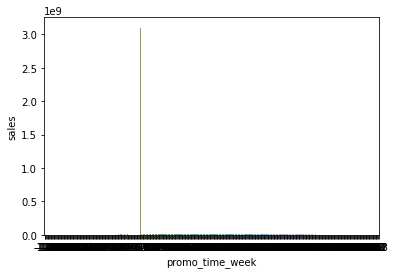

In [61]:
# gráfico ruim de analisar.
aux1 = df4[["promo_time_week", "sales"]].groupby("promo_time_week").sum().reset_index()
sns.barplot (x="promo_time_week", y="sales", data=aux1);



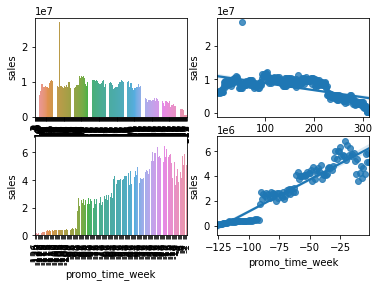

In [62]:
# aqui iremos particionar as informações para ver melhor o gráfico
# P.S. Para jogar os dados no Modelo (ML) não particiona as informações, tem que colocar os dados inteiros para testar e treinar o modelo
aux1 = df4[["promo_time_week", "sales"]].groupby("promo_time_week").sum().reset_index()

plt.subplot(2,2,1)
aux2 = aux1[aux1["promo_time_week"]>0] #promo extendido
sns.barplot (x="promo_time_week", y="sales", data=aux2);
plt.xticks(rotation=90);

# ver gráfico que mostra a tendencia decrescente
plt.subplot(2,2,2)
sns.regplot (x="promo_time_week", y="sales", data=aux2);

plt.subplot(2,2,3)
aux3 = aux1[aux1["promo_time_week"]<0] #promo regular
sns.barplot (x="promo_time_week", y="sales", data=aux3);
plt.xticks(rotation=90);

# ver gráfico que mostra a tendencia crescente
plt.subplot(2,2,4)
sns.regplot (x="promo_time_week", y="sales", data=aux3);



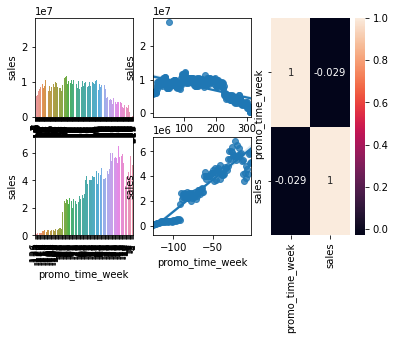

In [63]:
#como teremos 5 graficos devemos usar o GridSpec

# P.S. Para jogar os dados no Modelo (ML) não particiona as informações, tem que colocar os dados inteiros para testar e treinar o modelo
# aqui iremos particionar as informações para ver melhor o gráfico
aux1 = df4[["promo_time_week", "sales"]].groupby("promo_time_week").sum().reset_index()

# esse código forma as posições dos gráficos de forma diferente do subplot(em quadrados/matriz)
grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1["promo_time_week"]>0] #promo extendido
sns.barplot (x="promo_time_week", y="sales", data=aux2);
plt.xticks(rotation=90);

# ver gráfico que mostra a tendencia decrescente
plt.subplot(grid[0,1])
sns.regplot (x="promo_time_week", y="sales", data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1["promo_time_week"]<0] #promo regular
sns.barplot (x="promo_time_week", y="sales", data=aux3);
plt.xticks(rotation=90);

# ver gráfico que mostra a tendencia crescente
plt.subplot(grid[1,1])
sns.regplot (x="promo_time_week", y="sales", data=aux3);

# ver a força da correlação
# aqui quero que ocupe as duas últimas linhas, por isso colocou de 2 para frente (:,2)

plt.subplot(grid[:,2])
sns.heatmap (aux1.corr(method="pearson"), annot=True); #annot=True mostra os valores no gráfico de correlação


##### <s> H5. Lojas com mais dias de promoção deveriam vender mais. </s> será validada na segunda etapa do CRISP

##### H6 Lojas com mais promoções consecutivas deveriam vender mais.
***falso*** lojas com mais promoções consecutivas vendem menos

In [64]:
df4[["promo", "promo2", "sales"]].groupby(["promo", "promo2"]).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


<AxesSubplot:>

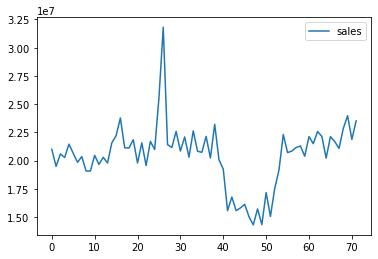

In [65]:
# vendas das lojas q tiveram nos dois periodos de promoção
# ver se lojas que entraram na promo tradicional teve mudança no comportamento ao entrar na promo extendida
aux1 = df4[(df4["promo"]==1) & (df4["promo2"]== 1)][["year_week", "sales"]].groupby("year_week").sum().reset_index()
aux1.plot()


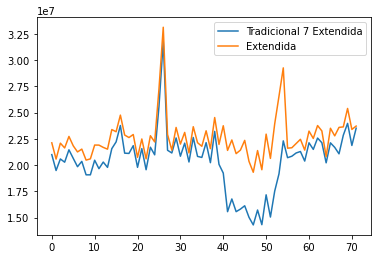

In [66]:
# vendas das lojas q tiveram nos dois periodos de promoção
# ver se lojas que entraram na promo tradicional (1) teve mudança no comportamento ao entrar na promo extendida(0)
aux1 = df4[(df4["promo"]==1) & (df4["promo2"]== 1)][["year_week", "sales"]].groupby("year_week").sum().reset_index()
ax = aux1.plot()

# aqui vamos analisar apenas as lojas que tiveram periodo da promo extendido
aux2 = df4[(df4["promo"]==1) & (df4["promo2"]== 0)][["year_week", "sales"]].groupby("year_week").sum().reset_index()
aux2.plot(ax=ax)#esse ax faz com que plot o grafico no mesmo grid

# faz a legenda do gráfico
ax.legend(labels=["Tradicional 7 Extendida", "Extendida"]);


##### H77. Lojas abertas durante o feriado de Natal deveriam vender mais.
***falso*** lojas abertas durante o feriado de Natal vendem menos

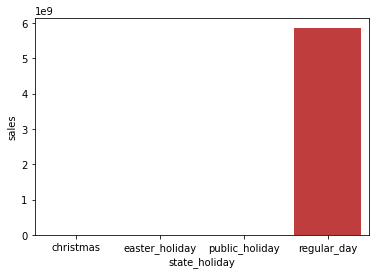

In [67]:
# gráfico ruim de analsar
aux1 = df4[["state_holiday", "sales"]].groupby("state_holiday").sum().reset_index()
sns.barplot(x="state_holiday", y="sales", data=aux1);


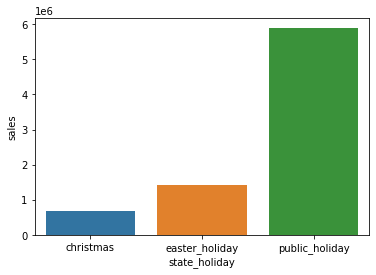

In [68]:
# aqui retiraremos os "regular_day" para trabalhar só com os feriados
aux = df4[df4["state_holiday"]!= "regular_day"]
aux1 = aux[["state_holiday", "sales"]].groupby("state_holiday").sum().reset_index()
sns.barplot(x="state_holiday", y="sales", data=aux1);


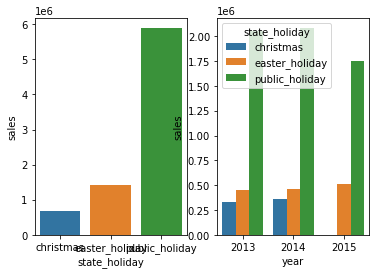

In [69]:
#calcular quantidade de vendas ao ano (para saber se o natal já vendeu mais em algum periodo)
# aqui retiraremos os "regular_day" para trabalhar só com os feriados
aux = df4[df4["state_holiday"]!= "regular_day"]

plt.subplot(1,2,1)
aux1 = aux[["state_holiday", "sales"]].groupby("state_holiday").sum().reset_index()
sns.barplot(x="state_holiday", y="sales", data=aux1);

plt.subplot(1,2,2)
aux2 = aux[["year", "state_holiday", "sales"]].groupby(["year", "state_holiday"]).sum().reset_index()
sns.barplot(x="year", y="sales", hue="state_holiday", data=aux2);


##### H8. Lojas deveriam vender mais ao longo dos anos.
***falso*** lojas vendem menos ao longo do ano

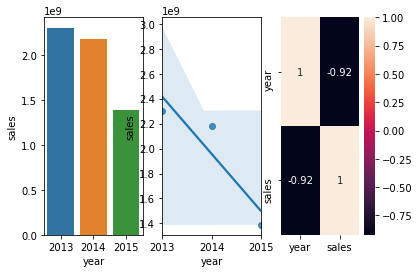

In [70]:
aux1 = df4[["year", "sales"]].groupby("year").sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x="year", y="sales", data=aux1);

#tendência
plt.subplot(1,3,2)
sns.regplot(x="year", y="sales", data=aux1);

#correlação (pegamos valores fechados, por isso nesse caso deu correlação alta, pois não tem 2015 fechado)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = "pearson"), annot=True); #annot=True para ver os valores


##### H9 Lojas deveriam vender mais no segundo semestre do ano.
***falso*** lojas vendem menos no segundo semestre do ano

##### H10 Lojas deveriam vender mais depois do dia 10 de cada mês.
***verdadeira*** lojas vendem mais depois do dia 10

In [71]:
# só para olhar
aux1["before_after"] = aux1["day"].apply(lambda x:"before_10_days" if x <= 10 else "after_10_days")
aux1.head(15)

KeyError: 'day'

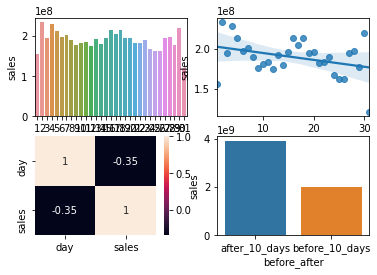

In [72]:
aux1 = df4[["day", "sales"]].groupby("day").sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x="day", y="sales", data=aux1);

#tendência
plt.subplot(2,2,2)
sns.regplot(x="day", y="sales", data=aux1);

#correlação (pegamos valores fechados, por isso nesse caso deu correlação alta, pois não tem 2015 fechado)
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = "pearson"), annot=True); #annot=True para ver os valores

aux1["before_after"] = aux1["day"].apply(lambda x:"before_10_days" if x <= 10 else "after_10_days")
aux2 = aux1[["before_after", "sales"]].groupby("before_after").sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x="before_after", y="sales", data=aux2);


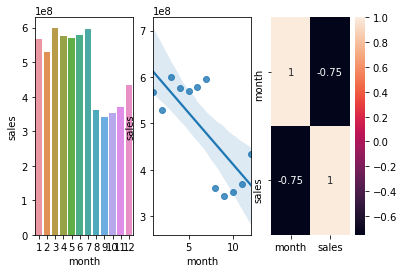

In [73]:
aux1 = df4[["month", "sales"]].groupby("month").sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x="month", y="sales", data=aux1);

#tendência
plt.subplot(1,3,2)
sns.regplot(x="month", y="sales", data=aux1);

#correlação (pegamos valores fechados, por isso nesse caso deu correlação alta, pois não tem 2015 fechado)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = "pearson"), annot=True); #annot=True para ver os valores


##### H11 Lojas deveriam vender menos aos finais de semana.
***verdadeira*** lojas vendem menos aos finais de semana

In [74]:
# para relembrar os nomes das colunas
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


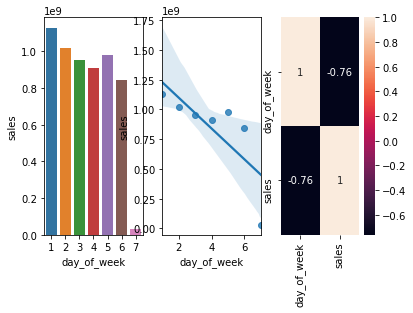

In [75]:
aux1 = df4[["day_of_week", "sales"]].groupby("day_of_week").sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x="day_of_week", y="sales", data=aux1);

#tendência
plt.subplot(1,3,2)
sns.regplot(x="day_of_week", y="sales", data=aux1);

#correlação (pegamos valores fechados, por isso nesse caso deu correlação alta, pois não tem 2015 fechado)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = "pearson"), annot=True); #annot=True para ver os valores


##### H12 Lojas deveriam vender menos durante os feriados escolares.
***verdadeira*** lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto (que vendem mais portano Falso)

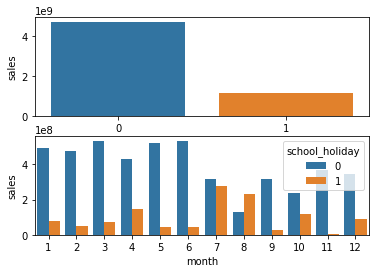

In [76]:
aux1 = df4[["school_holiday", "sales"]].groupby("school_holiday").sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x="school_holiday", y="sales", data=aux1);

aux2 = df4[["month", "school_holiday", "sales"]].groupby(["month", "school_holiday"]).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x="month", y="sales", hue="school_holiday", data=aux2);



## 4.2.1 Resumo das Hipóteses

In [77]:
from tabulate import tabulate

In [78]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
]

print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


In [79]:
# esses códigs estão meramente para analisamos os dados de treino com o que fizemos na EDA, pode ser retirado depois 
cols_selected_boruta

NameError: name 'cols_selected_boruta' is not defined

In [ ]:
# esses códigs estão meramente para analisamos os dados de treino com o que fizemos na EDA, pode ser retirado depois 
# aqui mostra o Month_sin como não relevante, mas colocaremos ele como relevante, temos essa liberdade ao ir fazendo os treinos e testes dos dados 
cols_not_selected_boruta

## 4.3 Análise multivariada

### 4.3.1 Numerical Attributes

In [80]:
# aqui apenas para olhar se temos variáveis numéricas
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


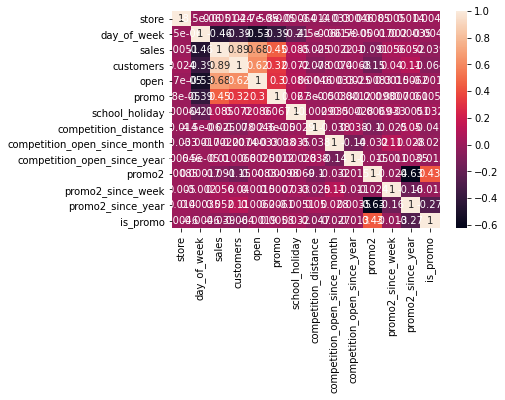

In [81]:
# fazer correlação entre todas as variáveis
# p.s Método de Pearson é para fazer a correlação entre duas variáveis numéricas 
correlation=num_attributes.corr(method="pearson")
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

In [82]:
# p.s Método de Cramer V é para fazer a correlação entre variáveis numéricas + categóricas ou entre variáveis categóricas
# aqui para ver se só temos variáveis categóricas
# aqui estou pegando o dataset da análise descritiva, então está defasado
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [83]:
# para pegar o dataset mais atual, incluindo apenas variaveis q se apresentam como object
# usaremos 3 colunas, o year se apresenta como object, mas ele é uma data
a = df4.select_dtypes (include = "object")
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [84]:
# como funciona, pega duas variáveis categóricas que queria fazer a correlação
# monta uma tabela onde vc tem nas linhas o state holiday e nas counas o store type
pd.crosstab(a["state_holiday"],a["store_type"])


store_type,a,b,c,d
state_holiday,,,,
christmas,4,66,0,1
easter_holiday,36,100,0,9
public_holiday,236,285,65,108
regular_day,456766,15109,112903,258650


In [85]:
# armazenando na variável cm
cm = pd.crosstab(a["state_holiday"],a["store_type"]).to_numpy()


In [86]:
# teste para validar as linhas estão pegando, basta trocar o nome da linha que quer ver
# Basicamente uma matriz de confusão(cm) ou tabela de contingência
a[(a["state_holiday"] == "christmas") & (a["store_type"] == "a")]


,state_holiday,store_type,assortment,year_week
241499,christmas,a,extended,2014-51
241977,christmas,a,extended,2014-51
616339,christmas,a,extended,2013-51
616908,christmas,a,extended,2013-51


In [87]:
# esse método já vem pronto para calcular, vem da biblioteca scipy
chi2 = ss.chi2_contingency(cm)


In [88]:
# aqui estamos olhando o primeiro valor, de teste por isso colocou [0]
# fórmula
# vamos aplicar ela como uma função para aplicarmos mais de uma vez
chi2 = ss.chi2_contingency(cm)[0]

n = cm.sum() #soma de todos os valores, usando a matriz de confusão

r,k =cm.shape #numero de linhas e colunas


In [89]:
# aqui vê a reposta, 4 resultados(1 teste, 2 p valor, 3 grau de liberdade 4 tabela de frequeência)
chi2

12792.159524019908

In [90]:
# Cramer V divisão sobre dois termos (quiquadrado/n e menor valor entre a coluna e linha) (quiquadrado, n=total de observação, k=números de coluna, r=números de linha)
# diferente do pearson que a correlação vai de -1 a 1, o v crame só vai de 0 a 1, não vemos correlação negativa
v = np.sqrt ((chi2/n) / (min(k-1,r-1)))

In [91]:
v

0.07106457093267678

In [92]:
# aqui estamos olhando o primeiro valor, de teste por isso colocou [0]
# fórmula
# vamos aplicar ela como uma função para aplicarmos mais de uma vez
def cramer_v(x,y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum() #soma de todos os valores, usando a matriz de confusão
    r,k =cm.shape #numero de linhas e colunas
    chi2 = ss.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1)+(r-1)/(n-1)) # p.s. cramer tem alto viés em relacnao ao estimador (precisa fazer uma correção por causa disso) tende a superestimar
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))
  

In [93]:
# fazendo uma tabela
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )

<AxesSubplot:>

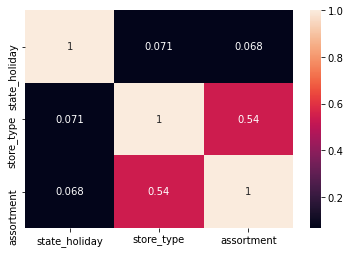

In [94]:
# correlacao entre as variáveis categóricas
sns.heatmap( d, annot=True )

# 5.0 Data Preparation (Passo 5)
### tipos de preparação de dados

In [95]:
df5 = df4.copy()

## 5.1 Normalização

In [96]:
# Ver quais variáveis irão ser normalizadas, olhando suas distribuções (na analise univariada em numerical variable)
# foi visto que não tem nenhum proxima da normal, então não sera feita a normalização

## 5.2 Rescaling

In [97]:
# quais variáveis usaremos?
# primeiro selecionar as variáveis numéricas
a = df5.select_dtypes(include=["int64", "float64"])

In [98]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


/Users/raquelrocha/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_distance'>

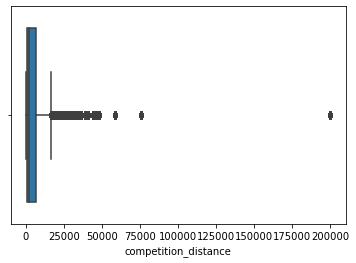

In [99]:
# ver se tem outliers expressivos ou não (para saber qual metodo usar - Min Max Scaler ou Robust Scaler)
sns.boxplot(df5["competition_distance"])


/Users/raquelrocha/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_time_month'>

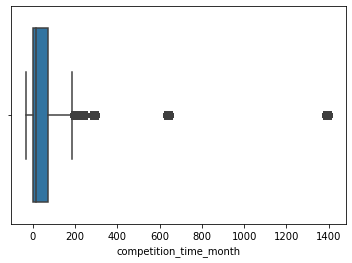

In [100]:
# ver se tem outliers expressivos ou não (para saber qual metodo usar - Min Max Scaler ou Robust Scaler)
sns.boxplot(df5["competition_time_month"])


/Users/raquelrocha/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='promo_time_week'>

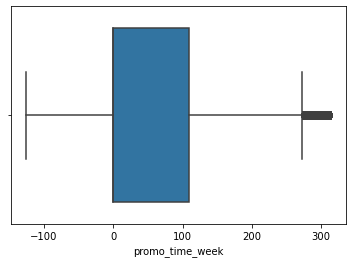

In [101]:
# ver se tem outliers expressivos ou não (para saber qual metodo usar - Min Max Scaler ou Robust Scaler)
sns.boxplot(df5["promo_time_week"])

In [102]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5["competition_distance"] = rs.fit_transform( df5[["competition_distance"]].values ) #encontra os parametros da fórmula e aplica nos dados

# competition time month
df5["competition_time_month"] = rs.fit_transform( df5[["competition_time_month"]].values ) #encontra os parametros da fórmula e aplica nos dados

# promo time week
df5["promo_time_week"] = mms.fit_transform( df5[["promo_time_week"]].values ) #encontra os parametros da fórmula e aplica nos dados

# year
df5["year"] = mms.fit_transform( df5[["year"]].values ) #encontra os parametros da fórmula e aplica nos dados


/Users/raquelrocha/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

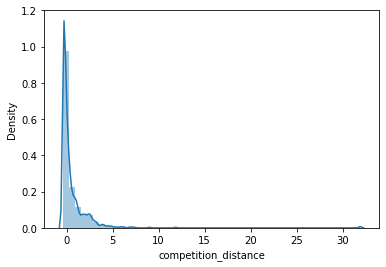

In [103]:
# observar a nova reescala 0 a 1
sns.distplot(df5["competition_distance"])

## 5.3 Transformação

### 5.3.1 Encoding

In [104]:
# pode ser q ao rodar de novo mude as informações, mas aqui veria o dataset como era antes das transformações de encoding abaixo
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [105]:
# para ver a comparação do que fizemos abaixo
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [106]:
# variáveis categóricas
# p.s. poderia ser feito o target encoder em todos abaixo, mas sempre assimilar antes pelo fealing qual encoder usar

# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=["state_holiday"], columns=["state_holiday"])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform ( df5["store_type"])

# assortment - Ordinal Encoding
assortment_dict = {"basic":1, "extra":2, "extended":3}
df5["assortment"] = df5["assortment"].map(assortment_dict)


In [107]:
# vendo as variáveis do assortment
df5['assortment'].drop_duplicates()

0      1
3      3
258    2
Name: assortment, dtype: int64

In [108]:
#separou essas porque tem uma natureza cíclica (year não tem essa natureza pq é sempre linear progressivo, não volta o tempo)

# month
# day
# week of year
# day of week

### 5.3.2 Response Variable Transformation

In [109]:
df5["sales"] = np.log1p( df5["sales"])

/Users/raquelrocha/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

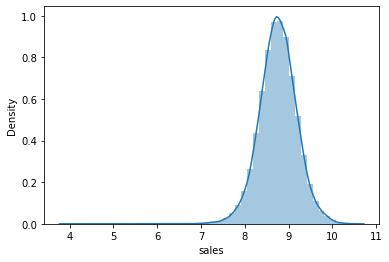

In [110]:
sns.distplot (df5["sales"])

### 5.3.3 Nature Transformation

In [111]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [112]:
# month
df5["month_sin"] = df5["month"].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5["month_cos"] = df5["month"].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5["day_sin"] = df5["day"].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5["day_cos"] = df5["day"].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5["week_of_year_sin"] = df5["week_of_year"].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5["week_of_year_cos"] = df5["week_of_year"].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# day of week
df5["day_of_week_sin"] = df5["day_of_week"].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5["day_of_week_cos"] = df5["day_of_week"].apply(lambda x: np.cos(x * (2. * np.pi/7)))


In [113]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0 Feature Selection (Passo 6)
### implementando o Boruta (algoritmo)

In [114]:
df6 = df5.copy()

In [115]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


## 6.1 Split dataframe into training and test dataset

In [116]:
# primeiro temos que deletar as variáveis originais
# durante o passo 5 mesclamos algumas variáveis então as originais não nos serve mais nesse passo

# aqui são as colunas que iremos deletar
cols_drop = ["week_of_year","day", "month", "day_of_week", "promo_since", "competition_since", "year_week"]

# recriar dataset sem as colunas cque foram "dropadas"
df6 = df6.drop(cols_drop, axis=1)

In [117]:
# iremos separar para esse problema de negócio, os dados de 6 semanas de vendas para teste e os dados do começo até esse ponto como treino
# aqui achamos a primeira data para conjunto de treino
df6[["store", "date"]].groupby("store").min().reset_index()


,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [118]:
# aqui achamos ate onde os dados irão em relação as vendas
df6[["store", "date"]].groupby("store").max().reset_index()


,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
...,...,...
1110,1111,2015-07-31
1111,1112,2015-07-31
1112,1113,2015-07-31
1113,1114,2015-07-31


In [119]:
# aqui pegaremos os dados das 6 semanas que queremos (data que começa a 6˚ semana)
df6[["store", "date"]].groupby("store").max().reset_index()["date"][0] - datetime.timedelta(days=6*7)


Timestamp('2015-06-19 00:00:00')

In [120]:
# training dataset
x_train = df6[df6["date"] < "2015-06-19"]
y_train = x_train["sales"]

# test dataset
x_test = df6[df6["date"] >= "2015-06-19"]
y_test = x_test["sales"]

# só para ver de fato se as datas batem com o começo e final do treino e do teste
print("Training Min Date: {}".format(x_train["date"].min()))
print("Training Max Date: {}".format(x_train["date"].max()))

print("\nTest Min Date: {}".format(x_train["date"].min()))
print("Test Max Date: {}".format(x_train["date"].max()))



Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2013-01-01 00:00:00
Test Max Date: 2015-06-18 00:00:00


## 6.2 Boruta as Feature Selector

In [121]:
# Aqui mostra que temos dados que não podemos usar date e sales q são dados de treino
# teremos q dar drop nessas colunas
x_train.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
47945,1,2015-06-18,8.443762,1,0,2,1,-0.170968,9,2008,...,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47946,2,2015-06-18,8.547722,1,0,0,1,-0.283871,11,2007,...,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47947,3,2015-06-18,8.927712,1,0,0,1,1.903226,12,2006,...,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47948,4,2015-06-18,9.091669,1,0,2,3,-0.275806,9,2009,...,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47949,5,2015-06-18,8.502080,1,0,0,1,4.448387,4,2015,...,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969


In [123]:
# implementar o Boruta
# usar a classe BorutaPy, rf = Random Forest verbose vai mostrando a contrução da árvore, random state faz com que o boruta parta do mesmo início(pq o boruta faz de forma aleatorio, então assim fazemos q parta do mesmo inico, pode ser qualquer número)

# training and test dataset for Boruta
x_train_n = x_train.drop(["date", "sales"], axis=1).values
y_train_n = y_train.values.ravel() #Ravel põe tudo dentro de um vetor

#definindo Random Forest Regressor
rf = RandomForestRegressor(n_jobs=-1)#n_jobs=-1 faz com que crie as arvoes em paralelo 

#definindo Boruta
boruta = BorutaPy(rf, n_estimators="auto", verbose=2, random_state=42).fit(x_train_n, y_train_n)



KeyboardInterrupt: 

### 6.2.1 Best Features from Boruta

In [ ]:
# aqui vamos usar as variáveis que o boruta rankeou/selecionou como mais importantes

cols_selected = boruta.support_.tolist()

# x_train_n é um array, vetor de numeros, não em mais os nomes das colunas, por isso não usemos essa variável
x_train_fs = x_train.drop(["date", "sales"], axis=1)

cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# aqui veremos as colunas que o boruta não rankeou/selecionou
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))



In [ ]:
cols_selected_boruta

In [ ]:
cols_not_selected_boruta

## 6.3 Manual Feature Selection

In [164]:
#aqui acrescentamos a lista o month_sin e week_of_year_sin
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos',
     'day_of_week_sin',
     'day_of_week_cos']

# adicionar essas variáveis que ficaram de fora, sales variável para treinar os algorítimos e o date usar para separar o conjunto de dados mais para frente
# columns to ad
feat_to_add = ["date", "sales"]

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)


In [125]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# 7.0 Machine Learning Modelling (Passo 7)
### Treinamento algoritmos de Machine Learning

In [126]:
#pegaremos as features que fizemos no boruta
X_train = x_train[cols_selected_boruta]
X_test = x_test[cols_selected_boruta]

## 7.1 Average Model

In [127]:
#p.s. o mean absolute ainda não tinha no sklearn, então iremos criar
def mean_absolute_percentage_error (y,yhat):
    return np.mean(np.abs(y - yhat) / y)


def ml_error (model_name, y, yhat):
    mae = mean_absolute_error (y, yhat) #dados verdadeiro e depois o aproximado
    mape = mean_absolute_percentage_error (y, yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({"Model Name": model_name,
                        "MAE": mae,
                        "MAPE": mape,
                        "RMSE":rmse}, index=[0]) #chave:valor


In [128]:
# média de cada vendas das lojas
# aqui vamos criar uma copia do x_test e criarrmos uma variável sales, colocaremos ela dentro de y_test, e usaremos o dataset original mas em ponto de teste.  
aux1 = X_test.copy()
aux1["sales"] = y_test.copy()

# aqui teremos a média das vendas de todas as lojas desse conjunto de dados
# Prediction
# p.s. yhat é quando tem valor estimado
aux2 = aux1[["store", "sales"]].groupby("store").mean().reset_index().rename(columns={"sales":"predictions"})
aux1 = pd.merge(aux1, aux2, how="left", on="store")
yhat_baseline = aux1["predictions"]

# Performance do modelo
# P.S. lembrar quando estavamos fazendo as transformações das variáves transformamos as variáveis resposta usando o logaritmo LOG, 5.3.2, então devemos voltar para os valores originais, então devemos aplicar o exponencial para voltar esses valores para orignal
baseline_result = ml_error("Average Model",  np.expm1(y_test), np.expm1(yhat_baseline))

baseline_result



,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [237]:
# model
lr = LinearRegression().fit(X_train, y_train)

# prediction
yhat_lr = lr.predict(X_test)

# performance
lr_result = ml_error("Linear Regression", np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [238]:
# o kfold colocaremos no valor de 5 iterações
# aqui mostra o erro real do modelo
lr_result_cv = cross_validation(X_training, 5, "Linear Regression", lr, verbose=False)
    

In [239]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [240]:
# model
lrr = Lasso(alpha=0.01).fit(X_train, y_train) #alpha mantém os dados em um espaço de range, diminuindo assim o tamanho, colocamos de 0.01, mas se diminuir o 01 para 00001, diminuindo, irá ter resultados melhores  

# prediction
yhat_lrr = lrr.predict(X_test)

# performance
lrr_result = ml_error("Linear Regression - Lasso", np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735


### 7.3.1 Lasso - Cross Validation

In [241]:
# o kfold colocaremos no valor de 5 iterações
# aqui mostra o erro real do modelo
lrr_result_cv = cross_validation(X_training, 5, "Lasso", lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [242]:
from sklearn.ensemble import RandomForestRegressor

In [243]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(X_train, y_train) # quantas árvores, para rodar em paralelo, a origem dos aleatórios, na pra de escolher as váriaveis  

# prediction
yhat_rf = rf.predict(X_test)

# performance
rf_result = ml_error("Random Forest Regressor", np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.893818,0.099967,1011.038517


### 7.4.1 Random Forest Regressor - Cross Validation

In [244]:
# o kfold colocaremos no valor de 5 iterações
# aqui mostra o erro real do modelo
rf_result_cv = cross_validation(X_training, 5, "Random Forest Regressor", rf, verbose=True)
rf_result_cv


KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.66 +/- 218.22,0.12 +/- 0.02,1255.81 +/- 318.76


## 7.5 XGBoost Regressor

In [324]:
# model
model_xgb = xgb.XGBRegressor( objective="reg:squarederror",#função objetiva
                              n_estimators=100, 
                              eta=0.01, # quantas passadas ele usa para azer o aprendizado
                              max_depth=10, # máxima ramificação que a árvore pode chegar
                              subsample=0.7, # quantas amostrars e porcentagens de todas as variáveis que tenho para fazer a amostragem para mostrar as mais interessantes
                              colsample_bytree=0.9).fit(X_train, y_train) # fazer o sample por cada uma das árvores
# prediction
yhat_xgb = model_xgb.predict(X_test)

# performance
xgb_result = ml_error("XGBoost Regressor", np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.669356,0.949477,7330.958645


### 7.5.1 XBoost Regressor - Cross Validation

In [268]:
# o kfold colocaremos no valor de 5 iterações
# aqui mostra o erro real do modelo
xgb_result_cv = cross_validation(X_training, 5, "XGBoost Regressor", model_xgb, verbose=False)
xgb_result_cv

[16:50:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:55:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:59:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "colsample_byte

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7047.99 +/- 587.62,0.95 +/- 0.0,7714.05 +/- 688.68


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [247]:
# comparar as performances de todos os modelos
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values("RMSE") # ordenar pelo menos rmse para olhar o modelo que tem o menor erro


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.893818,0.099967,1011.038517
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704880,0.289106,2744.451735
0,XGBoots Regressor,6683.602213,0.949501,7330.746126


### 7.6.2 Real Performance - Cross Validation

In [250]:
# comparar as performances de todos os modelos
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,837.66 +/- 218.22,0.12 +/- 0.02,1255.81 +/- 318.76
0,XBoost Regressor,7047.99 +/- 587.62,0.95 +/- 0.0,7714.05 +/- 688.68


In [251]:
# só para separar da info acima, os códigos abaixo foram durante a construção 

In [252]:
# aqui começamos o Time Series Cross validation
# aqui o dataset não tem nem a data e nem as vendas e no dataset x_train minusculo, temos todas até as váriáveis menos importantes. Aqui então teremos q mexer
X_train.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
47945,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47946,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47947,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47948,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47949,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969


In [253]:
# Time Series Data Preparation
# esse é colocado depois no passo 7.0 rever na aula 34
X_training = x_train [cols_selected_boruta_full]

In [168]:
X_training.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,...,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,date,sales
47945,1,1,2,1,-0.170968,9,2008,0,25,2015,...,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.443762
47946,2,1,0,1,-0.283871,11,2007,1,13,2010,...,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.547722
47947,3,1,0,1,1.903226,12,2006,1,14,2011,...,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.927712
47948,4,1,2,3,-0.275806,9,2009,0,25,2015,...,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,9.091669
47949,5,1,0,1,4.448387,4,2015,0,25,2015,...,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.502080


In [177]:
# Função para implementar o cross validation, aqui só explicando de qual range irá pegar a informação
# nosso modelo vai pegando da ultima semana para tras, para ir ao contrario usamos  o reversed
for k in reversed(range(1,6)):
    print(k)


5
4
3
2
1


In [207]:
# primeiras 6 semanas, pegou a data maxima da ultima venda e diminuiu com 6 últimas semanas, que iniciaremos o validation data
# kfold (temos que pegar a media e desvio padrão de cada um deles para ter a performance real do modelo)
# k=1 (não precisamos mais desse valor pois o k já faz parte do for)

#criar listas para fazer concatenação dos valores
def cross_validation(X_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print("\nKFold Number:{}".format(k))

        # start and end date for validation
        validation_start_date = X_training["date"].max() - datetime.timedelta(days=k*6*7) # ao alterar o número 1 e 0 abaixo, vai mudando o tempo do k=1 k=2 k=3 etapas d ciclo do cross validation, p.s. colocamos a função usando o k no lugar do número
        validation_end_date = X_training["date"].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset, filtrar para tornar os outros dados como dados de treino
        # aqui é o primeiro ciclo
        training = X_training[X_training["date"] < validation_start_date]

        # aqui é o segundo ciclo
        validation = X_training[(X_training["date"] >= validation_start_date) & (X_training["date"] <= validation_end_date)]

        # training and validation dataset
        # Training
        Xtraining = training.drop(["date", "sales"], axis=1)
        Ytraining = training["sales"]

        # Validation
        Xvalidation = validation.drop(["date", "sales"], axis=1)
        Yvalidation = validation["sales"]

        # model (treinar o modelo)
        m = model.fit(Xtraining, Ytraining)
        # prediction
        yhat = m.predict(Xvalidation)                        
        # performance   
        m_result = ml_error(model_name, np.expm1(Yvalidation), np.expm1(yhat))
        #print(lr_result)

        # Store performance of each kfold iteration
        mae_list.append(m_result["MAE"])
        mape_list.append(m_result["MAPE"])
        rmse_list.append(m_result["RMSE"])

    #aqui vamos calcular a média e mostrar um DataFrame pronto
    # cv = cross validation
    # métrica real de performance
    return pd.DataFrame ({"Model Name": model_name,
                      "MAE CV": np.round(np.mean(mae_list),2).astype(str)+ ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                      "MAPE CV": np.round(np.mean(mape_list),2).astype(str)+ ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                      "RMSE CV": np.round(np.mean(rmse_list),2).astype(str)+ ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index =[0])



In [209]:
X_training = x_train [cols_selected_boruta_full]

In [210]:
# já mostra dataframe com valores medio e com desvio padrão
#podemos colocar Lasso e outros no lugar de linear regression
model = LinearRegression()
a = cross_validation(X_training, 5, "Linear Regression", model, verbose=True )


KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


In [211]:
a

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


### 7.6.0 códigos usados no processo, sem mais utilidade

In [222]:
mae_list = []
mape_list = []
rmse_list = []

In [223]:
# Só para ver a lista
#p.s.aqui vera a lista quando da construção da função
mae_list

[]

In [212]:
# aqui ja retiramos as colunas que não farão parte do treino
X_training.head()


,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,...,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,date,sales
47945,1,1,2,1,-0.170968,9,2008,0,25,2015,...,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.443762
47946,2,1,0,1,-0.283871,11,2007,1,13,2010,...,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.547722
47947,3,1,0,1,1.903226,12,2006,1,14,2011,...,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.927712
47948,4,1,2,3,-0.275806,9,2009,0,25,2015,...,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,9.091669
47949,5,1,0,1,4.448387,4,2015,0,25,2015,...,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.502080


In [214]:
# start and end date for validation
validation_start_date = X_training["date"].max() - datetime.timedelta(days=k*6*7) # ao alterar o número 1 e 0 abaixo, vai mudando o tempo do k=1 k=2 k=3 etapas d ciclo do cross validation, p.s. colocamos a função usando o k no lugar do número
validation_end_date = X_training["date"].max() - datetime.timedelta(days=(k-1)*6*7)

# filtering dataset, filtrar para tornar os outros dados como dados de treino
# aqui é o primeiro ciclo
training = X_training[X_training["date"] < validation_start_date]

# aqui é o segundo ciclo
validation = X_training[(X_training["date"] >= validation_start_date) & (X_training["date"] <= validation_end_date)]


In [215]:
# Olhando os dados vemos que aqui tem as colunas que não podemos colocar para o treino, date e sales
# temos que excluir elas para treinar o modelo de treino
training.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,...,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,date,sales
95890,1,1,2,1,-0.170968,9,2008,0,19,2015,...,0.5,-0.866025,0.951057,0.309017,0.748511,-0.663123,0.433884,-0.900969,2015-05-06,8.509363
95891,2,1,0,1,-0.283871,11,2007,1,13,2010,...,0.5,-0.866025,0.951057,0.309017,0.748511,-0.663123,0.433884,-0.900969,2015-05-06,8.788593
95892,3,1,0,1,1.903226,12,2006,1,14,2011,...,0.5,-0.866025,0.951057,0.309017,0.748511,-0.663123,0.433884,-0.900969,2015-05-06,9.110188
95893,4,1,2,3,-0.275806,9,2009,0,19,2015,...,0.5,-0.866025,0.951057,0.309017,0.748511,-0.663123,0.433884,-0.900969,2015-05-06,9.238733
95894,5,1,0,1,4.448387,4,2015,0,19,2015,...,0.5,-0.866025,0.951057,0.309017,0.748511,-0.663123,0.433884,-0.900969,2015-05-06,8.664923


In [216]:
training["date"].min()

Timestamp('2013-01-01 00:00:00')

In [217]:
training["date"].max()

Timestamp('2015-05-06 00:00:00')

In [218]:
validation["date"].min()

Timestamp('2015-05-07 00:00:00')

In [219]:
validation["date"].max()

Timestamp('2015-06-18 00:00:00')

# 8.0 Hyperparameter Fine Tunning (Passo 8)
### Implementação  Fine Tunning

### 8.1 Random Search

In [270]:
import random
import warnings
warnings.filterwarnings ("ignore") 

In [351]:
# criação do dicionário
param = {
    "n_estimators" : [15, 17, 25, 30, 35],
    "eta" : [0.01, 0.03],
    "max_depth" : [3, 5 , 9], # números espaçados, para não criar uma lista grande para não ter muitas iterações , mas esses valores podem mudar
    "subsample" : [0.1, 0.5, 0.7], # porcentagem
    "colsample_bytree" : [0.3, 0.7, 0.9],
    "min_child_weight" : [3, 8, 15]
        }

MAX_EVAL = 2 # aqui colocamos quantas iteracões teremos

In [352]:
# Guardar o resultado 
final_result = pd.DataFrame()

# para escolher os números aleatoreamente
for i in range (MAX_EVAL): # uma constante que diz quantas iteraçnoes teremos
    # choose values for parameters randonly
    hp = { k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)
    
    # model
    # aqui colocaremos uma lista, uma chave valor com definicão dos melhores parametros.
    model_xgb = xgb.XGBRegressor( objective="reg:squarederror",# função objetiva
                                  n_estimators=hp["n_estimators"], 
                                  eta=hp["eta"], # 
                                  max_depth=hp["max_depth"], # 
                                  subsample=hp["subsample"], # 
                                  colsample_bytree=hp["colsample_bytree"], # aqui não precisamos mais treinar como no XGBoost 
                                  min_child_weight=hp["min_child_weight"]) # acrescentamos mais um parâmetro

    
    # performance
    result = cross_validation(X_training, 2, "XGBoost Regressor", model_xgb, verbose=False)
    final_result = pd.concat([final_result, result]) # concatenar usando método concat

final_result    


{'n_estimators': 15, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 17, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7392.48 +/- 128.13,0.99 +/- 0.0,8048.43 +/- 175.29
0,XGBoost Regressor,7420.51 +/- 128.29,1.0 +/- 0.0,8074.64 +/- 175.38


### 8.2 Final Model (modelo que tem os parâmetros que maximizam o aprendizado)

In [353]:
# criação do dicionário
# colocaremos os parametros que o modelo escolher como melhor
param_tuned = {
    "n_estimators": 17,
    "eta": 0.01,
    "max_depth": 5, # números espaçados, para não criar uma lista grande para não ter muitas iterações , mas esses valores podem mudar
    "subsample": 0.5, # porcentagem
    "colsample_bytree": 0.7,
    "min_child_weight": 15
        }

 #MAX_EVAL = 2 # aqui colocamos quantas iteracões teremos

In [364]:
# model
# aqui colocaremos uma lista, uma chave valor com definição dos melhores parâmetros.
model_xgb_tuned = xgb.XGBRegressor( objective="reg:squarederror", # função objetiva
                                   n_estimators=param_tuned["n_estimators"], 
                                   eta=param_tuned["eta"],
                                   max_depth=param_tuned["max_depth"],
                                   subsample=param_tuned["subsample"], 
                                   colsample_bytree=param_tuned["colsample_bytree"], # aqui não precisamos mais treinar como no XGBoost 
                                   min_child_weight=param_tuned["min_child_weight"]).fit(X_train, y_train) # acrescentamos mais um parâmetro

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(X_test)

# pegamos o modelo mais otimizado e rodar sobre os dados de teste
# performance
xgb_result_tuned = ml_error("XGBoost Regressor", np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned 


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6990.131651,0.999151,7624.134186


#### 8.0 Cálculos MAE MAPE RMSE - módulo 09 só para estudos

In [308]:
#aqui vemos se esses valores MAE são altos ou baixos
np.expm1(y_test).min()

569.0000000000002

In [309]:
np.expm1(y_test).max()

41550.99999999998

In [310]:
np.expm1(y_test).max()-np.expm1(y_test).min()

40981.99999999998

In [311]:
# para entender o Mape
np.expm1(y_test).mean

<bound method NDFrame._add_numeric_operations.<locals>.mean of 0         5263.0
1         6064.0
2         8314.0
3        13995.0
4         4822.0
          ...   
47940     5618.0
47941    11240.0
47942     7114.0
47943    21834.0
47944     8291.0
Name: sales, Length: 41396, dtype: float64>

In [312]:
Dividi o valor do erro pela média para entender a porcentagem
665/6695

SyntaxError: invalid syntax (1781168285.py, line 1)

In [313]:
# dividi o valor rmse pela média ( professor usa o rmse para fazer melhoria do machine learning
956/6695

0.14279312920089618

In [314]:
# Cálculo MPE
# função que tem no ponto 7.1 duplica e faz esse
def mean_percentage_error (y,yhat):
    return np.mean((y - yhat) / y)

In [315]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe


NameError: name 'yhat_xgb_tuned' is not defined

# 9.0 Tradução e Interpretação do Erro (Passo 9)

In [379]:
df9 = x_test[cols_selected_boruta_full]

# rescale voltar os dados para a escala original (de log para exponencial)
df9["sales"] = np.expm1(df9["sales"])
df9["predictions"] = np.expm1(yhat_xgb_tuned)


## 9.1 Business Performance

In [373]:
# Sum os Predictions, para saber quanto de dinheiro irá entrar com o modelo.
df91 = df9 [["store", "predictions"]].groupby("store").sum().reset_index()

# MAE MAPE, para reportar o valor de negócio.
# Modelo do MAE
df9_aux1 = df9[["store", "sales", "predictions"]].groupby("store").apply(lambda x:mean_absolute_error(x["sales"], x["predictions"])).reset_index().rename(columns = {0:"MAE"}) # primeiro argumento são as vendas reais (sales) e segundo argumento (são as predições)

#Modelo MAPE
df9_aux2 = df9[["store", "sales", "predictions"]].groupby("store").apply(lambda x:mean_absolute_percentage_error(x["sales"], x["predictions"])).reset_index().rename(columns = {0:"MAPE"}) # primeiro argumento são as vendas reais (sales) e segundo argumento (são as predições)

# Merge (Aqui reuniremos os valores MAE e MAPE)
#inner = comparar as lojas, por isso coloca store no "on"
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how="inner", on="store")
#Aqui colocaremos o MAE e o MAPE junto somas das predições por loja
df92 = pd.merge(df91, df9_aux3, how="inner", on="store")

# Scenarios
df92["worst_scenario"] = df92["predictions"] - df92["MAE"]
df92["best_scenario"] = df92["predictions"] + df92["MAE"]

# order columns, ver nessa ordem os dados
df92 = df92[["store", "predictions", "worst_scenario", "best_scenario", "MAE", "MAPE"]]



In [369]:
df9_aux1.head()

,store,MAE
0,1,4381.974962
1,2,4939.284054
2,3,6865.051785
3,4,9978.080589
4,5,4505.999628


In [374]:
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,186.926407,-4195.048555,4568.901369,4381.974962,0.998822
1,2,182.489990,-4756.794064,5121.774044,4939.284054,0.998916
2,3,183.083969,-6681.967815,7048.135754,6865.051785,0.999228
3,4,189.018219,-9789.062370,10167.098808,9978.080589,0.999475
4,5,183.013779,-4322.985849,4689.013406,4505.999628,0.998748


In [375]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
98,99,184.771973,-5447.774731,5817.318676,5632.546703,0.999078
1114,1115,185.289032,-6790.081535,7160.659599,6975.370567,0.999253
733,734,186.616241,-4946.204941,5319.437424,5132.821183,0.998918
539,540,187.164627,-6838.722816,7213.052070,7025.887443,0.999242


In [376]:
# mostrar lojas por ordem de mais desafiadoras de trabalhar, ex: MAPE de 50%, difícil usar pq o numero é muito alto
df92.sort_values("MAPE", ascending=False).head()


,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1113,1114,201.917160,-22568.949944,22972.784264,22770.867104,0.999756
261,262,219.410736,-20967.021572,21405.843044,21186.432308,0.999750
816,817,187.143219,-20667.474532,21041.760970,20854.617751,0.999748
841,842,188.849030,-20176.236132,20553.934191,20365.085161,0.999743
250,251,193.792068,-18455.564903,18843.149039,18649.356971,0.999712


<AxesSubplot:xlabel='store', ylabel='MAPE'>

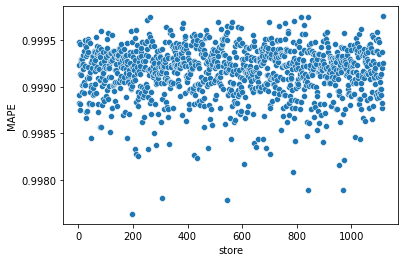

In [377]:
sns.scatterplot(x="store", y="MAPE", data=df92)


## 9.2 Total Performance

In [386]:
# resumo de melhor e pior cenário
# f no 2 é importante para mostrar o valor em reais
df93 = df92[["predictions", "worst_scenario", "best_scenario"]].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={"index":"Scenario", 0:"Values"})
df93["Values"] = df93["Values"].map("RS{:,.2f}".format)
df93


,Scenario,Values
0,predictions,"RS208,260.19"
1,worst_scenario,"RS-7,578,394.01"
2,best_scenario,"RS7,994,914.36"


## 9.3 Machine Learning Performance

In [387]:
df9["error"] = df9["sales"] - df9["predictions"]
df9["error_rate"] = df9["predictions"] / df9["sales"]


<AxesSubplot:xlabel='predictions', ylabel='error'>

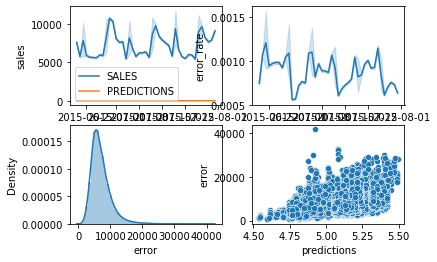

In [391]:
# Uma forma para ver como estão as predições e vendas ao longo do tempo

# Gráfico 1 (subplot)
#data é as vendas no dia a dia ao longo das 6 semanas
plt.subplot(2,2,1)
sns.lineplot( x="date", y="sales", data = df9, label = "SALES")
sns.lineplot( x="date", y="predictions", data = df9, label = "PREDICTIONS")

# Gráfico 2 (subplot)
# error rate, taxa de erro por dia
plt.subplot(2,2,2)
sns.lineplot( x="date", y="error_rate", data = df9)

# Gráfico 3 (distplot, mostra distribuição)
# error rate, taxa de erro por dia
plt.subplot(2,2,3)
sns.distplot(df9 ["error"])

# Gráfico 4 (distplot, mostra distribuição, residuo)
# error rate, taxa de erro por dia
plt.subplot(2,2,4)
sns.scatterplot(df9 ["predictions"], df9 ["error"]) # primeiro atributo eixo x e o segundo é o eixo y 


In [355]:
import pickle

In [356]:
# salvar o modelo treinado, com os novos valores
pickle.dump(model_xgb_tuned, open())

TypeError: open() missing required argument 'file' (pos 1)